# Ortho Dataset Multiclass Classification with Deep Learning

## Notes and References
- Link to Source Data: http://archive.ics.uci.edu/ml/datasets/vertebral+column
- Link to additional inforamtion on GitHub: https://github.com/van-william/azure-ml-demo

# Import Libraries and Initial Setup

In [124]:
#Standard Python ML Libraries
import logging
import json
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import arff
import requests, zipfile
from IPython.display import Image
from IPython.display import display
import sys
import os
import math
import numpy as np
import seaborn as sns
import random
import pickle
import joblib
random.seed(42)

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

#Explainer
from eli5.sklearn import PermutationImportance
import shap

In [33]:
# Custom Heatmap Plot
# Source: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def corr_plot(df):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 10))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 11, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Extract Data from UCI Site in python

In [34]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'

# Download the data
r = requests.get(f_zip)

# Write the zip file to the azure machine learning
with open('./ortho-zip.zip', 'wb') as f:
    f.write(r.content)

# Open and unzip the file
with zipfile.ZipFile('./ortho-zip.zip', 'r') as zip:
    # printing all the contents of the zip file
    #print('directory: \n')
    #zip.printdir()
    # extracting all the files
    zip.extractall()

# Load the .arff file
data_dict = arff.load(open('./column_3C_weka.arff'))
# Create a pandas dataframe from the .arff file
data_arff = data_dict["data"]
attributes = data_dict['attributes']
features = [item[0] for item in attributes]
ortho_3C_df = pd.DataFrame(data = data_arff, columns = features)
ortho_3C_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


In [35]:
ortho_3C_df['class'].value_counts()

Spondylolisthesis    150
Normal               100
Hernia                60
Name: class, dtype: int64

In [36]:
num_features = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
                'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']

In [37]:
label_decoder = {'Normal': 0,
 'Hernia':1,
 'Spondylolisthesis':2 }

In [76]:
#ortho_3C_df['label'] = ortho_3C_df['class'].apply(lambda x: label_decoder[x])
features = ortho_3C_df[num_features].values
labels = ortho_3C_df['class'].values

In [77]:
X_train, X_val, y_train, y_val = train_test_split(features,labels,test_size=0.20, random_state = 42)

In [78]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Model Training and Evaluation

In [79]:
#Initialize base model
clf = SVC(kernel = 'linear')

#Create grid search cross validation for SVC
params = {'C':list(np.arange(0.1,10,0.1))}

In [80]:
grid = GridSearchCV(clf, params, refit=True)
grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                               0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                               1.2000000000000002, 1.3000000000000003,
                               1.4000000000000001, 1.5000000000000002, 1.6,
                               1.7000000000000002, 1.8000000000000003,
                               1.9000000000000001, 2.0, 2.1, 2.2,
                               2.3000000000000003, 2.4000000000000004,
                               2.5000000000000004, 2.6, 2.7, 2.8000000000000003,
                               2.9000000000000004, 3.0000000000000004, ...]})

In [81]:
y_pred = grid.predict(X_val)

In [82]:
best_clf = grid.best_estimator_

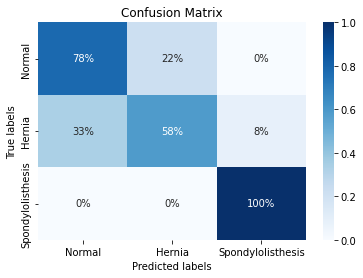

In [94]:
label_order = ['Normal','Hernia','Spondylolisthesis']
ax= plt.subplot()
cm = confusion_matrix(y_val, y_pred, normalize='true',labels=label_order)
sns.heatmap(cm, annot=True, fmt='.0%', cmap="Blues", ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(label_order);
ax.yaxis.set_ticklabels(label_order);

In [107]:
feature_importance = pd.DataFrame({'feature': num_features,
                                   'importance': best_clf.coef_[0],
                                  'importance_abs': abs(best_clf.coef_[0])})

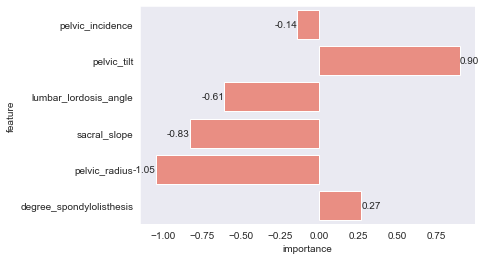

In [118]:
sns.set_style("dark")
bar = sns.barplot(x='importance', y='feature', data=feature_importance, color='salmon')
bar.bar_label(bar.containers[0], fmt='%.2f');

(0.0, 1.5)

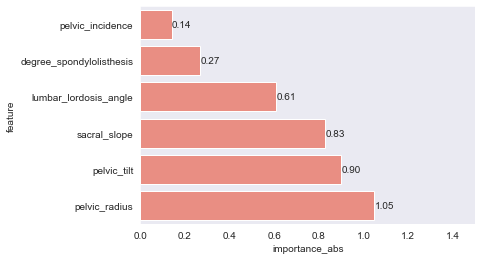

In [123]:
bar_abs = sns.barplot(x='importance_abs', y='feature', data=feature_importance.sort_values('importance_abs'), color='salmon')
bar_abs.bar_label(bar_abs.containers[0], fmt='%.2f');
bar_abs.set_xlim(0, 1.5)

In [126]:
# save model
joblib.dump(best_clf, '../static/models/sk_model/model.pkl') 

['../static/models/sk_model/model.pkl']